In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Reproducibility
RANDOM_STATE = 42

sns.set(style="whitegrid")


In [2]:
# Load dataset (Colab path)
df = pd.read_csv("../data/simulated_cytokine_data.csv")

# Quick sanity checks
df.head()


,donor_id,group,sex,age,IFN_gamma,IP10,IL2,TNF_alpha,response_label
0,1,Vaccinated,M,33,387.166140,1033.078503,306.097114,147.741918,1
1,2,Vaccinated,F,38,283.567005,839.166202,177.353970,216.198113,1
2,3,Vaccinated,F,34,695.434816,1471.566793,46.950037,156.853659,1
3,4,Vaccinated,F,23,257.489783,1076.810524,129.353095,159.018106,0
4,5,Vaccinated,M,46,362.794217,1244.824296,60.336646,128.183267,0


In [3]:
# Check structure and labels
df.info()
df["group"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   donor_id        150 non-null    int64  
 1   group           150 non-null    object 
 2   sex             150 non-null    object 
 3   age             150 non-null    int64  
 4   IFN_gamma       150 non-null    float64
 5   IP10            150 non-null    float64
 6   IL2             150 non-null    float64
 7   TNF_alpha       150 non-null    float64
 8   response_label  150 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 10.7+ KB


,count
group,
Vaccinated,100
Control,50


In [8]:
# Define feature columns (immune markers only)
feature_cols = [
    "IFN_gamma",
    "IL2",
    "TNF_alpha",
    "IP10"
]

X = df[feature_cols]

# Clean group labels defensively
df["group_clean"] = df["group"].str.strip().str.lower()

# Encode labels
y = df["group_clean"].map({"control": 0, "vaccinated": 1})

# Sanity check
y.isna().sum(), y.value_counts()



(np.int64(0),
 group_clean
 1    100
 0     50
 Name: count, dtype: int64)

In [9]:
# Define pipeline: scaling + logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        random_state=RANDOM_STATE
    ))
])


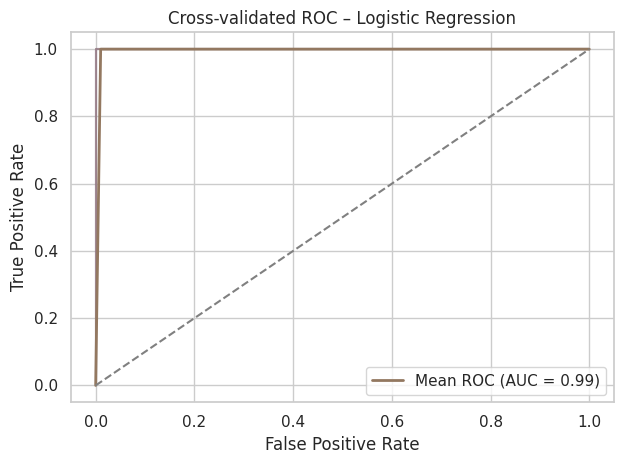

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure()

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    plt.plot(fpr, tpr, alpha=0.3)

# Mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(
    mean_fpr,
    mean_tpr,
    label=f"Mean ROC (AUC = {mean_auc:.2f})",
    linewidth=2
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cross-validated ROC – Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [12]:
# Fit model on full dataset to inspect coefficients
pipeline.fit(X, y)

coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": pipeline.named_steps["model"].coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
0,IFN_gamma,2.004218
3,IP10,1.944194
1,IL2,0.879474
2,TNF_alpha,-0.091551


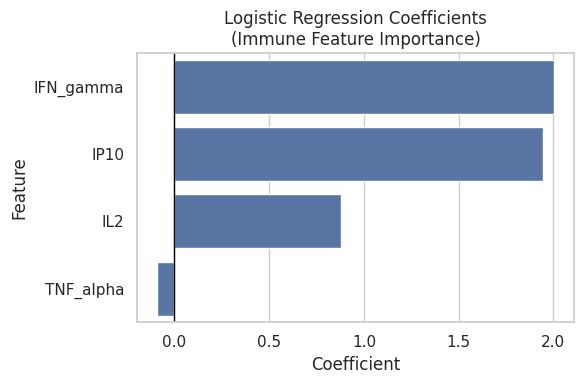

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=coef_df,
    x="Coefficient",
    y="Feature",
    orient="h"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression Coefficients\n(Immune Feature Importance)")
plt.tight_layout()
plt.show()


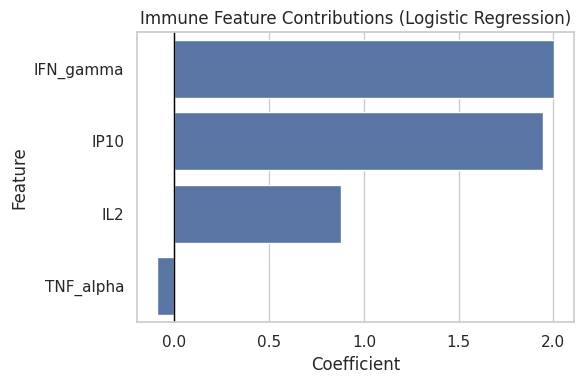

In [14]:
import os
os.makedirs("../results/figures", exist_ok=True)

plt.figure(figsize=(6,4))
sns.barplot(
    data=coef_df,
    x="Coefficient",
    y="Feature",
    orient="h"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Immune Feature Contributions (Logistic Regression)")
plt.tight_layout()
plt.savefig("../results/figures/feature_coefficients.png", dpi=300)
plt.show()



**Interpretation and Limitations**

The high discriminative performance observed here is expected given the simulated nature of the dataset and should be interpreted as a demonstration of analytical methodology rather than real-world diagnostic accuracy. Feature coefficients highlight cytokines contributing to group separation and are presented to illustrate biological interpretability rather than causal inference.